# To do

1. Freeze previous layers, train only upsampling layer, and test 
2. Mirror the image in ```evaluate_list``` in ```evaluate.py```
3. Ablation tests

# Starter code

In [1]:
# this mounts your Google Drive to the Colab VM.
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
# In case of OSError: [Errno 107] Transport endpoint is not connected, restart Kernel

FOLDERNAME = 'Depth_Estimation'
assert FOLDERNAME is not None, "[!] Enter the foldername."

# now that we've mounted your Drive, this ensures that
# the Python interpreter of the Colab VM can load
# python files from within it.
import sys
sys.path.append('/content/drive/My Drive/{}'.format(FOLDERNAME))


# this changes the working directory to the folder, and allows us to perform version control operations
%cd drive/My\ Drive/$FOLDERNAME
!git config --global user.email "arjun2000ashok@gmail.com"
!git config --global user.name "Arjun Ashok"



import matplotlib.pyplot as plt
import torch
torch.manual_seed(0)

import numpy as np
np.random.seed(0)

from PIL import Image
from io import BytesIO
%matplotlib inline

%load_ext autoreload
%autoreload 2
!pip install wandb -qq
import wandb
!wandb login

# Git commit and push

In [ ]:
# !git reset --soft HEAD~1 # UNDO PREVIOUS COMMIT AND PUT THOSE FILES IN STAGING AREA
# !git status # - VIEW STAGED, UNTRACKED FILES
# !git reset HEAD -- . # - TO UNSTAGE FILES
# !git log # LOG

In [ ]:
# !git add .
# !git commit -m 'Test data evaluated, metrics displayed in notebook'
# !git push -u origin master

[master 7883b67] Test data evaluated, metrics displayed in notebook
 7 files changed, 55 insertions(+), 8 deletions(-)
 rewrite Depth Estimation.ipynb (88%)
 rewrite __pycache__/evaluate.cpython-36.pyc (64%)
Counting objects: 12, done.
Delta compression using up to 2 threads.
Compressing objects: 100% (12/12), done.
Writing objects: 100% (12/12), 300.55 KiB | 6.53 MiB/s, done.
Total 12 (delta 6), reused 0 (delta 0)
remote: Resolving deltas: 100% (6/6), completed with 6 local objects.
To https://github.com/aiarjun/Monocular-Depth-Estimation.git
   21f2982..7883b67  master -> master
Branch 'master' set up to track remote branch 'master' from 'origin'.


In [2]:
# !git pull

Already up to date.


# Evaluate on complete validation set

Get the model file(either the last epoch or the best test or both), run a test on the complete validation set, get metrics,loss etc.

After this,

1. Train more, if needed
2. Test on the test set
3. Architecture search, transfer learning mode switch, ablation tests(arc 1,2,3,.. w/wout transfer learning on different test sets
4. KITTI training - if time permits

In [ ]:
# do not click this cell again

from model.net import DenseDepth
from model.dataloader import DataLoaders
from utils import *
from evaluate import *

dataloaders = DataLoaders('nyu_data.zip')

In [ ]:
checkpoint_file = 'epoch_13.pth.tar'

wandb.init(id="kaggle_script_test_5", project="depth_estimation", resume='allow') # we will not watching the model for now
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model = DenseDepth(); model = model.to(device)
print('Loading checkpoint from cloud storage:',checkpoint_file)
load_checkpoint(wandb.restore(checkpoint_file).name, model)
print('Loaded checkpoint from cloud storage:',checkpoint_file) 
test_metrics_collection = []

In [ ]:
config = {'test_batch_size': 1, 'test_metrics_log_interval': 50}
loss, metrics = evaluate_full(model, dataloaders.get_val_dataloader, config)
test_metrics_collection.append({'config': config, 'loss': loss, 'metrics': metrics})

# Single image evaluate code

In [ ]:
# run the previous cells before running this cell (model loading, dataloader, config)
batch_size = 2
test_images, test_depths, test_preds, test_loss, test_metrics = evaluate(model, dataloaders.get_val_dataloader, batch_size)

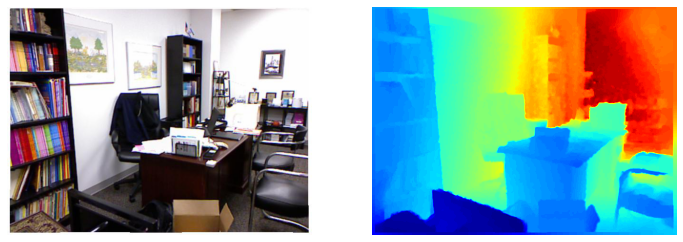

In [ ]:
plot_sample_tensor(test_images[1], test_depths[1])

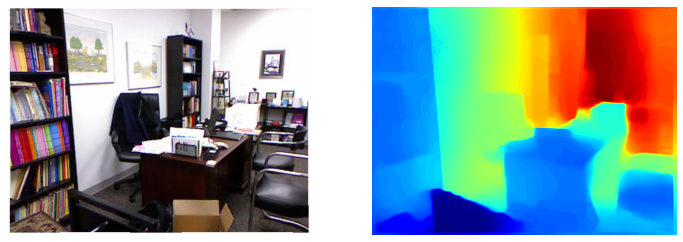

In [ ]:
plot_sample_tensor(test_images[1], test_preds[1])

# Exploring the test.zip

In [2]:
from model.dataloader import get_test_data
samples, crop = get_test_data('nyu_test.zip') # gets img and depth data of same size(480 x 640)

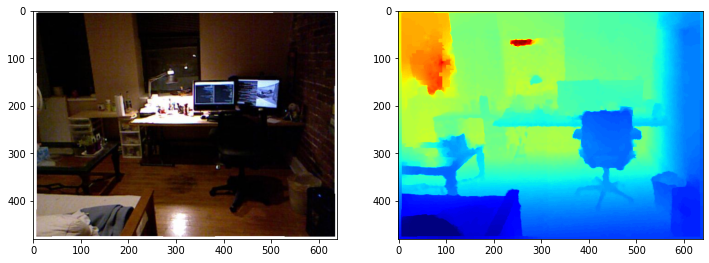

In [8]:
#without the eigen crop

from utils import *
import random

# idx = random.randint(0, len(samples))
sample = samples[idx]

img = sample['img']
depth = sample['depth']


# flipped_image = sample['img'].numpy()[:,:,::-1].copy()
# img = torch.from_numpy(sample['img'].numpy()[:,:,::-1].copy())
# flipped_depth = sample['depth'].numpy()[:,:,::-1].copy()
# depth = torch.from_numpy(flipped_depth)

plot_sample_tensor(img, depth)

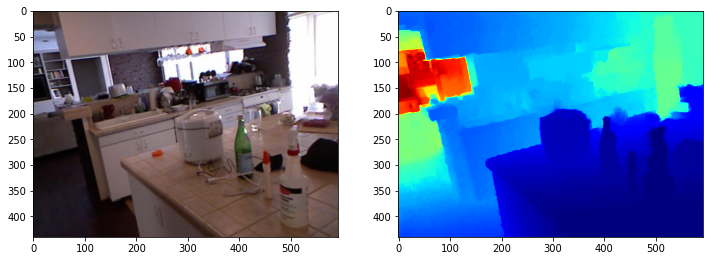

In [ ]:
#with the eigen crop [execute previous cell]

img_crop = sample['img'][:, crop[0]:crop[1]+1, crop[2]:crop[3]+1]
depth_crop = sample['depth'][:, crop[0]:crop[1]+1, crop[2]:crop[3]+1]
plot_sample_tensor(img_crop, depth_crop)

# Evaluate on test set

In [2]:
from model.net import DenseDepth
from utils import *

checkpoint_file = 'epoch_13.pth.tar'

wandb.init(id="kaggle_script_test_5", project="depth_estimation", resume='allow') # we will not watching the model for now
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model = DenseDepth(); model = model.to(device)
print('Loading checkpoint from cloud storage:',checkpoint_file)
load_checkpoint(wandb.restore(checkpoint_file).name, model)
print('Loaded checkpoint from cloud storage:',checkpoint_file) 

Failed to connect to W&B servers after 10 seconds.                    Letting user process proceed while attempting to reconnect.
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/checkpoints/densenet121-a639ec97.pth
Streaming file created twice in same run: /content/drive/My Drive/Depth_Estimation/wandb/run-20200717_072447-kaggle_script_test_5/wandb-history.jsonl
Streaming file created twice in same run: /content/drive/My Drive/Depth_Estimation/wandb/run-20200717_072447-kaggle_script_test_5/wandb-events.jsonl


Loading checkpoint from cloud storage: epoch_13.pth.tar
Loaded checkpoint from cloud storage: epoch_13.pth.tar


In [4]:
# run only once
from model.dataloader import get_test_data
samples, crop = get_test_data('nyu_test.zip') # gets img and depth data of same size(480 x 640)
print('Number of samples: ', len(samples))

Number of samples:  654


In [9]:
from evaluate import evaluate_list

test_batch_size = 6

test_metrics = evaluate_list(model, samples, crop, test_batch_size)

In [10]:
display(test_metrics)

{'d1_accuracy': tensor(0.8369, device='cuda:0'),
 'd2_accuracy': tensor(0.9706, device='cuda:0'),
 'd3_accuracy': tensor(0.9936, device='cuda:0'),
 'log10_error': tensor(0.0550, device='cuda:0'),
 'relative_err': tensor(0.1303, device='cuda:0'),
 'rmse': tensor(0.5529, device='cuda:0')}

# Results
No mirroring at inference:

```
{'d1_accuracy': tensor(0.8366, device='cuda:0'),
 'd2_accuracy': tensor(0.9705, device='cuda:0'),
 'd3_accuracy': tensor(0.9935, device='cuda:0'),
 'log10_error': tensor(0.0552, device='cuda:0'),
 'relative_err': tensor(0.1305, device='cuda:0'),
 'rmse': tensor(0.552833, device='cuda:0')}
```

Mirroring after upsampling, and averaging w 0.5
```
{'d1_accuracy': tensor(0.8369, device='cuda:0'),
 'd2_accuracy': tensor(0.9706, device='cuda:0'),
 'd3_accuracy': tensor(0.9936, device='cuda:0'),
 'log10_error': tensor(0.0550, device='cuda:0'),
 'relative_err': tensor(0.1303, device='cuda:0'),
 'rmse': tensor(0.5529, device='cuda:0')}
```

Mirroring before upsampling, and averaging w 0.5
